# Exercise 6.5: K-Means Clustering Analysis
## NYC Healthcare Access Equity Analysis

This notebook performs unsupervised machine learning using the k-means clustering algorithm to uncover hidden patterns across NYC census tracts. The analysis will standardize health and demographic variables, determine the optimal number of clusters using the elbow technique, and group census tracts into meaningful segments. The goal is to identify distinct community profiles that can inform targeted public health interventions.

In [41]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sklearn

In [42]:
# Import scikit-learn modules for clustering
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import pylab as pl

In [43]:
# Load master dataset
master = pd.read_csv('/Users/jessduong/Documents/CF/Achievement 6/02 data/Prepared Data/nyc_health_master.csv')

In [44]:
# Check shape
print('Full dataset:', master.shape)
print(master.dtypes)

Full dataset: (10699, 14)
Year                  int64
census_tract          int64
county               object
latitude            float64
longitude           float64
tract_population    float64
diabetes_pct        float64
obesity_pct         float64
depression_pct      float64
stroke_pct          float64
median_income       float64
pct_uninsured       float64
pct_age_65plus      float64
facility_count      float64
dtype: object


In [45]:
# Select only meaningful numeric columns for clustering
# Drop: Year (identifier), census_tract (identifier), county (categorical),
# latitude/longitude (geographic, not health-related)
cluster_cols = ['tract_population', 'diabetes_pct', 'obesity_pct', 'depression_pct',
                'stroke_pct', 'median_income', 'pct_uninsured', 'pct_age_65plus',
                'facility_count']

df_cluster = master[cluster_cols]

In [46]:
# Check for missing values
print('Shape:', df_cluster.shape)
print('\nMissing values:')
print(df_cluster.isnull().sum())

Shape: (10699, 9)

Missing values:
tract_population       0
diabetes_pct           0
obesity_pct            0
depression_pct      2117
stroke_pct             0
median_income          0
pct_uninsured          0
pct_age_65plus         0
facility_count         0
dtype: int64


In [47]:
# Check which years have missing depression data
print(master[master['depression_pct'].isnull()]['Year'].value_counts())

Year
2018    2117
Name: count, dtype: int64


In [48]:
# Drop rows with missing depression data (all from 2018)
df_cluster = df_cluster.dropna()

In [49]:
# Confirm clean dataset
print('Shape after dropping missing values:', df_cluster.shape)
print('Missing values:', df_cluster.isnull().sum().sum())

Shape after dropping missing values: (8582, 9)
Missing values: 0


In [50]:
# Standardize the data so all variables are on the same scale
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_cluster)

In [51]:
# Convert back to dataframe for readability
df_scaled = pd.DataFrame(df_scaled, columns=cluster_cols)

In [52]:
# Verify standardization (means should be ~0, std should be ~1)
print(df_scaled.describe().round(2))

       tract_population  diabetes_pct  obesity_pct  depression_pct  \
count           8582.00       8582.00      8582.00         8582.00   
mean              -0.00         -0.00         0.00           -0.00   
std                1.00          1.00         1.00            1.00   
min               -1.84         -2.61        -2.31           -2.94   
25%               -0.73         -0.61        -0.81           -0.72   
50%               -0.17         -0.01        -0.05           -0.05   
75%                0.50          0.61         0.76            0.63   
max               10.93          9.51         3.35            6.05   

       stroke_pct  median_income  pct_uninsured  pct_age_65plus  \
count     8582.00        8582.00        8582.00         8582.00   
mean         0.00          -0.00          -0.00           -0.00   
std          1.00           1.00           1.00            1.00   
min         -2.27          -2.03          -1.72           -1.66   
25%         -0.55          -0.06  

### Data Preparation
- Removed non-numeric and identifier columns (Year, census_tract, county, latitude, longitude)
- Dropped 2,117 rows from 2018 due to missing depression data (8,582 rows remain, above the 5,000 minimum)
- Standardized all variables using StandardScaler so that no single variable dominates the clustering due to scale differencesThen we move to Step 3: Elbow Technique

In [53]:
# Use the elbow technique to determine optimal number of clusters
# Test a range of 1 to 10 clusters
kmeans_list = [KMeans(n_clusters=i, random_state=42, n_init=10) for i in range(1, 11)]

In [54]:
# Calculate the score (inertia) for each cluster count
scores = [kmeans_list[i].fit(df_scaled).inertia_ for i in range(len(kmeans_list))]

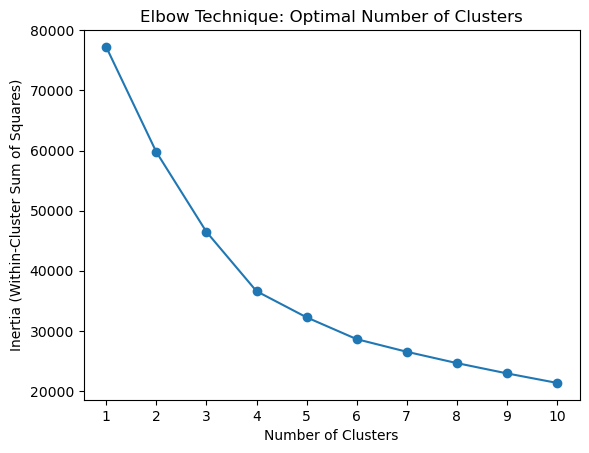

In [55]:
# Plot the elbow curve
pl.plot(range(1, 11), scores, marker='o')
pl.xlabel('Number of Clusters')
pl.ylabel('Inertia (Within-Cluster Sum of Squares)')
pl.title('Elbow Technique: Optimal Number of Clusters')
pl.xticks(range(1, 11))
plt.savefig('/Users/jessduong/Documents/CF/Achievement 6/04 analysis/visualizations/elbow_chart.png', dpi=150, bbox_inches='tight')
plt.show()

### Elbow Technique Results

The elbow curve shows the steepest decline in inertia between 1 and 3 clusters, with diminishing returns after 4. The "elbow" appears around 3-4 clusters. I chose **4 clusters** because it provides enough granularity to identify distinct community health profiles across NYC census tracts while remaining interpretable for stakeholders. Beyond 4 clusters, the reduction in inertia is minimal, meaning additional clusters would not meaningfully improve the groupings.

In [56]:
# Run k-means algorithm with 4 clusters
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)

In [57]:
# Fit the model to the standardized data
kmeans.fit(df_scaled)

# Attach cluster labels back to the original (non-scaled) dataframe
df_cluster_results = df_cluster.reset_index(drop=True)
df_cluster_results['cluster'] = kmeans.labels_

In [58]:
# Check how many observations fall into each cluster
print(df_cluster_results['cluster'].value_counts().sort_index())

cluster
0    1583
1    2897
2    2598
3    1504
Name: count, dtype: int64


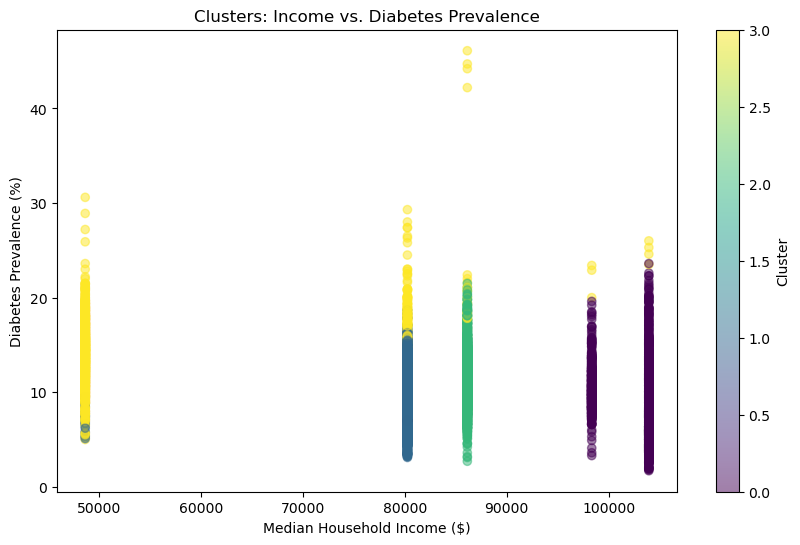

In [59]:
# Scatterplot 1: Median Income vs Diabetes Prevalence
plt.figure(figsize=(10, 6))
scatter = plt.scatter(df_cluster_results['median_income'], 
                      df_cluster_results['diabetes_pct'],
                      c=df_cluster_results['cluster'], 
                      cmap='viridis', alpha=0.5)  # Color by cluster
plt.colorbar(scatter, label='Cluster')
plt.xlabel('Median Household Income ($)')
plt.ylabel('Diabetes Prevalence (%)')
plt.title('Clusters: Income vs. Diabetes Prevalence')
plt.savefig('/Users/jessduong/Documents/CF/Achievement 6/04 analysis/visualizations/cluster_scatter_income_vs_diabetes.png', dpi=150, bbox_inches='tight')
plt.show()

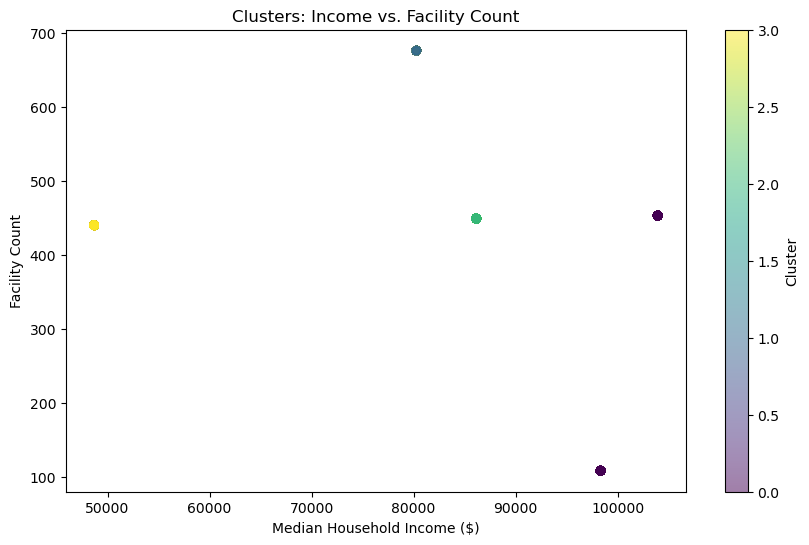

In [60]:
# Scatterplot 2: Median Income vs Facility Count
plt.figure(figsize=(10, 6))
scatter = plt.scatter(df_cluster_results['median_income'], 
                      df_cluster_results['facility_count'],
                      c=df_cluster_results['cluster'], 
                      cmap='viridis', alpha=0.5)  # Color by cluster
plt.colorbar(scatter, label='Cluster')
plt.xlabel('Median Household Income ($)')
plt.ylabel('Facility Count')
plt.title('Clusters: Income vs. Facility Count')
plt.savefig('/Users/jessduong/Documents/CF/Achievement 6/04 analysis/visualizations/cluster_scatter_income_vs_facility_count.png', dpi=150, bbox_inches='tight')
plt.show()

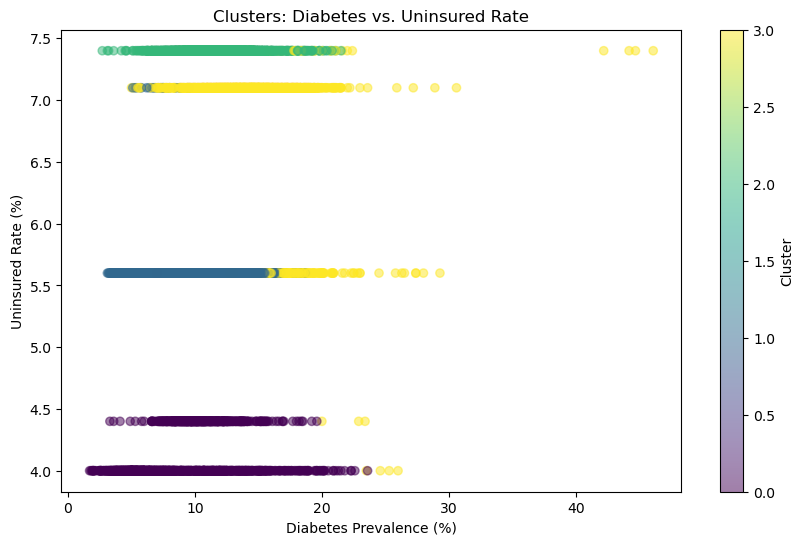

In [61]:
# Scatterplot 3: Diabetes vs Uninsured Rate
plt.figure(figsize=(10, 6))
scatter = plt.scatter(df_cluster_results['diabetes_pct'], 
                      df_cluster_results['pct_uninsured'],
                      c=df_cluster_results['cluster'], 
                      cmap='viridis', alpha=0.5)  # Color by cluster
plt.colorbar(scatter, label='Cluster')
plt.xlabel('Diabetes Prevalence (%)')
plt.ylabel('Uninsured Rate (%)')
plt.title('Clusters: Diabetes vs. Uninsured Rate')
plt.savefig('/Users/jessduong/Documents/CF/Achievement 6/04 analysis/visualizations/cluster_scatter_diabetes_vs_uninsured_rate.png', dpi=150, bbox_inches='tight')
plt.show()

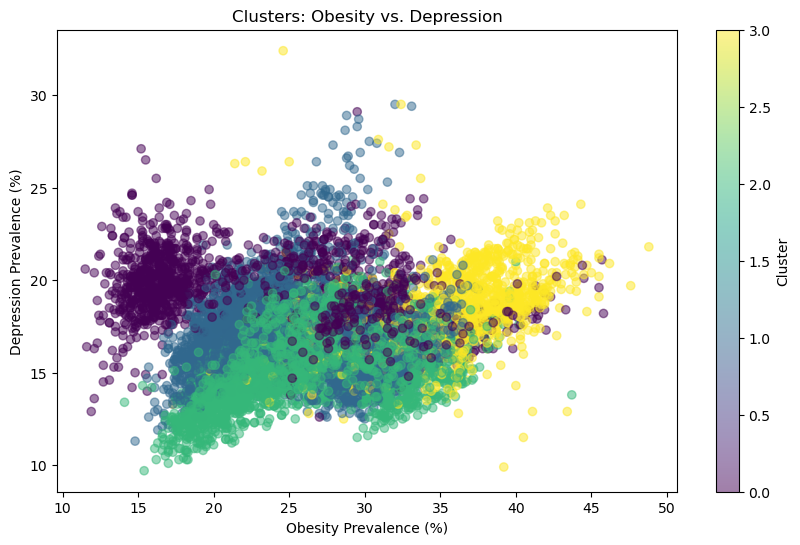

In [62]:
# Scatterplot 4: Obesity vs Depression
plt.figure(figsize=(10, 6))
scatter = plt.scatter(df_cluster_results['obesity_pct'], 
                      df_cluster_results['depression_pct'],
                      c=df_cluster_results['cluster'], 
                      cmap='viridis', alpha=0.5)  # Color by cluster
plt.colorbar(scatter, label='Cluster')
plt.xlabel('Obesity Prevalence (%)')
plt.ylabel('Depression Prevalence (%)')
plt.title('Clusters: Obesity vs. Depression')
plt.savefig('/Users/jessduong/Documents/CF/Achievement 6/04 analysis/visualizations/cluster_scatter_obsity_vs_depression.png', dpi=150, bbox_inches='tight')
plt.show()

In [63]:
# Calculate descriptive statistics for each cluster
cluster_stats = df_cluster_results.groupby('cluster').mean().round(2)

# Display the results
print(cluster_stats.to_string())

         tract_population  diabetes_pct  obesity_pct  depression_pct  stroke_pct  median_income  pct_uninsured  pct_age_65plus  facility_count
cluster                                                                                                                                       
0                 5272.67          8.97        23.13           19.43        2.61      102356.53           4.11           17.07          357.03
1                 3341.26         10.27        25.46           16.91        3.10       80023.13           5.61           15.49          674.21
2                 3462.53         11.69        25.91           15.37        2.97       86149.70           7.40           16.80          449.00
3                 4192.71         14.79        34.28           18.10        4.11       52656.88           6.94           14.65          462.59


### Descriptive Statistics Discussion

The groupby statistics confirm clear separation between clusters. Cluster 3 has the lowest median income (52,657 USD) and the highest rates of diabetes (14.8%), obesity (34.3%), and stroke (4.1%). Cluster 0 is the opposite, with the highest income (102,357 USD) having the best health outcomes. Clusters 1 and 2 sit in the middle with similar income but differ in uninsured rates (5.6% vs. 7.4%) and facility access (674 vs. 449). These statistics confirm that the k-means algorithm successfully identified meaningful health-equity groupings.

### Cluster Interpretation

Based on the descriptive statistics, the 4 clusters represent distinct community health profiles:

**Cluster 0 — "High-Income, Healthier Tracts" (1,583 tracts)**
- Highest income ($102,357), lowest uninsured rate (4.1%)
- Lowest diabetes (9.0%) and stroke (2.6%) rates
- Highest depression (19.4%); potentially reflecting higher diagnosis/reporting rates in wealthier areas
- Likely represents Manhattan and Staten Island tracts

**Cluster 1 — "Mid-Income Urban Core" (2,897 tracts)**
- Moderate income ($80,023), moderate health outcomes
- Highest facility count (674); most healthcare infrastructure
- Moderate diabetes (10.3%) and obesity (25.5%)
- Likely represents Brooklyn tracts with dense urban healthcare infrastructure

**Cluster 2 — "Mid-Income, Higher Uninsured" (2,598 tracts)**
- Similar income to Cluster 1 ($86,150) but highest uninsured rate (7.4%)
- Moderate diabetes (11.7%) and obesity (25.9%)
- Lowest depression (15.4%); possibly reflecting underdiagnosis rather than better mental health
- Likely represents Queens tracts where insurance coverage gaps exist

**Cluster 3 — "Low-Income, High Health Burden" (1,504 tracts)**
- Lowest income ($52,657), highest diabetes (14.8%), obesity (34.3%), and stroke (4.1%)
- Youngest population (lowest % age 65+) yet worst health outcomes
- Moderate facility count (463); facilities are present but health outcomes remain poor
- Likely represents Bronx tracts, reinforcing the "Bronx paradox" from earlier analysis

### Key Insight
The clusters reinforce the central finding from Exercises 6.2 and 6.4: income is the primary driver of health disparities. Cluster 3 (low-income) has dramatically worse outcomes than Cluster 0 (high-income) across every health metric except depression. Notably, Cluster 3 has a younger population with worse health, suggesting that chronic disease burden begins earlier in low-income communities.

The depression anomaly is also worth noting: wealthier tracts show higher depression rates, Which likely reflects better access to mental health screening and diagnosis rather than truly higher depression prevalence.

### Future Use of Cluster Analysis
These cluster profiles could be used to:
- **Target public health interventions** by directing resources to Cluster 3 tracts for chronic disease prevention programs
- **Guide insurance outreach** by focusing enrollment campaigns on Cluster 2 tracts with the highest uninsured rates
- **Inform facility planning** by recognizing that Cluster 3 has facilities present but outcomes remain poor, suggesting the need for different types of services (preventive care, nutrition programs) rather than more facilities
- **Support grant applications** by using cluster profiles as evidence of community health needs for federal and state funding

In [64]:
# Merge cluster labels back to the full master dataset
# First, we need the rows that MATCH the clustering subset (non-null depression, 8,582 rows)
master_for_clusters = master[master['depression_pct'].notna()].reset_index(drop=True)

In [65]:
# Add the cluster column
master_for_clusters['cluster'] = kmeans.labels_

In [66]:
# Verify
print('Shape:', master_for_clusters.shape)
print('Columns:', master_for_clusters.columns.tolist())
print('\nCluster counts:')
print(master_for_clusters['cluster'].value_counts().sort_index())

Shape: (8582, 15)
Columns: ['Year', 'census_tract', 'county', 'latitude', 'longitude', 'tract_population', 'diabetes_pct', 'obesity_pct', 'depression_pct', 'stroke_pct', 'median_income', 'pct_uninsured', 'pct_age_65plus', 'facility_count', 'cluster']

Cluster counts:
cluster
0    1583
1    2897
2    2598
3    1504
Name: count, dtype: int64


In [67]:
# Now create the FULL Tableau-ready dataset (all 10,699 rows)
# Rows without clusters (2018) will have cluster = NaN
master_tableau = master.copy()

In [68]:
# Create a matching key using the original index
cluster_lookup = master[master['depression_pct'].notna()].reset_index()
cluster_lookup['cluster'] = kmeans.labels_

In [69]:
# Merge back on original index
master_tableau = master_tableau.merge(
    cluster_lookup[['index', 'cluster']],
    left_index=True,
    right_on='index',
    how='left'
).drop(columns='index')

In [70]:
print('Full dataset shape:', master_tableau.shape)
print('\nCluster distribution (NaN = 2018 rows without clusters):')
print(master_tableau['cluster'].value_counts(dropna=False).sort_index())

Full dataset shape: (10699, 15)

Cluster distribution (NaN = 2018 rows without clusters):
cluster
0.0    1583
1.0    2897
2.0    2598
3.0    1504
NaN    2117
Name: count, dtype: int64


In [71]:
# Export both versions as CSV for Tableau
output_path = '/Users/jessduong/Documents/CF/Achievement 6/02 data/Prepared Data/'

In [72]:
# Version 1: Full dataset (10,699 rows) - cluster is NaN for 2018
master_tableau.to_csv(output_path + 'nyc_health_tableau_full.csv', index=False)

In [73]:
# Version 2: Clustered subset only (8,582 rows) - all rows have clusters
master_for_clusters.to_csv(output_path + 'nyc_health_tableau_clustered.csv', index=False)

In [74]:
print('Exported:')
print(f'  Full dataset: {master_tableau.shape[0]} rows, {master_tableau.shape[1]} columns')
print(f'  Clustered subset: {master_for_clusters.shape[0]} rows, {master_for_clusters.shape[1]} columns')
print('\nFiles saved to:', output_path)

Exported:
  Full dataset: 10699 rows, 15 columns
  Clustered subset: 8582 rows, 15 columns

Files saved to: /Users/jessduong/Documents/CF/Achievement 6/02 data/Prepared Data/


### Tableau-Ready Data Export

Two CSV files exported for Tableau dashboard:

1. **nyc_health_tableau_full.csv** (10,699 rows) — Complete dataset with all years. Cluster column is blank for 2018 rows (depression data was unavailable). Use this for non-clustering charts like maps, scatterplots, and borough comparisons.

2. **nyc_health_tableau_clustered.csv** (8,582 rows) — Only rows with cluster assignments (2019-2022). Use this for all cluster-related visualizations like cluster maps, cluster comparison charts, and profile analysis.

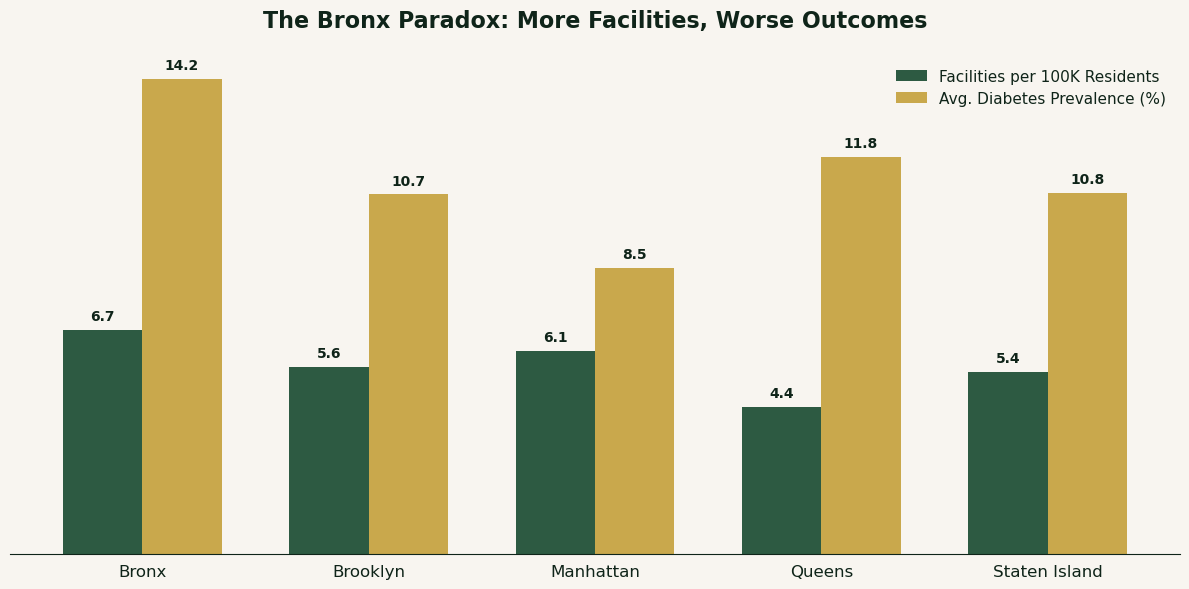

Saved: bronx_paradox_paired_bar.jpg and .png


In [76]:
#The Bronx Paradox (Combined Paired Bar Chart)

# Portfolio Colors
forest_green = '#2d5a42'
gold = '#c9a84c'
cream = '#f8f5f0'
dark_green = '#0f2419'

# Verified Data (from Tableau)
boroughs = ['Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island']
facilities_per_100k = [6.690, 5.578, 6.075, 4.386, 5.438]
diabetes_pct = [14.182, 10.727, 8.535, 11.838, 10.768]

# Chart Setup
x = np.arange(len(boroughs))
width = 0.35  # width of each bar

fig, ax = plt.subplots(figsize=(12, 6))
fig.patch.set_facecolor(cream)
ax.set_facecolor(cream)

# Draw the two sets of bars
bars1 = ax.bar(x - width/2, facilities_per_100k, width,
               label='Facilities per 100K Residents',
               color=forest_green, edgecolor='none')

bars2 = ax.bar(x + width/2, diabetes_pct, width,
               label='Avg. Diabetes Prevalence (%)',
               color=gold, edgecolor='none')

# Add value labels on top of each bar
for bar in bars1:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.2,
            f'{height:.1f}', ha='center', va='bottom',
            fontsize=10, fontweight='bold', color=dark_green)

for bar in bars2:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.2,
            f'{height:.1f}', ha='center', va='bottom',
            fontsize=10, fontweight='bold', color=dark_green)

# Labels and Title
ax.set_title('The Bronx Paradox: More Facilities, Worse Outcomes',
             fontsize=16, fontweight='bold', color=dark_green, pad=20)
ax.set_xticks(x)
ax.set_xticklabels(boroughs, fontsize=12, color=dark_green)
ax.set_ylabel('')  # no y-axis label needed — legend explains both metrics

# Clean up: remove gridlines, spines, etc.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color(dark_green)
ax.tick_params(left=False, labelleft=False)  # hide y-axis ticks and numbers
ax.tick_params(bottom=False)

# Legend
ax.legend(loc='upper right', fontsize=11, frameon=False,
          labelcolor=dark_green)

plt.tight_layout()

# Save image
plt.savefig('/Users/jessduong/Documents/CF/Achievement 6/04 analysis/visualizations/bronx_paradox_paired_bar.png',
            dpi=300, bbox_inches='tight', facecolor=cream)

plt.show()
print("Saved: bronx_paradox_paired_bar.jpg and .png")

### The Bronx Paradox: Facilities vs. Health Outcomes

This paired bar chart compares healthcare facility density (per 100K residents) with average diabetes prevalence across NYC's five boroughs. The Bronx has both the highest facility rate (6.7 per 100K) and the worst diabetes outcome (14.2%), while Manhattan has moderate facility access but the lowest diabetes rate (8.5%). This counterintuitive pattern suggests that simply adding more facilities does not improve health outcomes — income and socioeconomic factors play a stronger role.

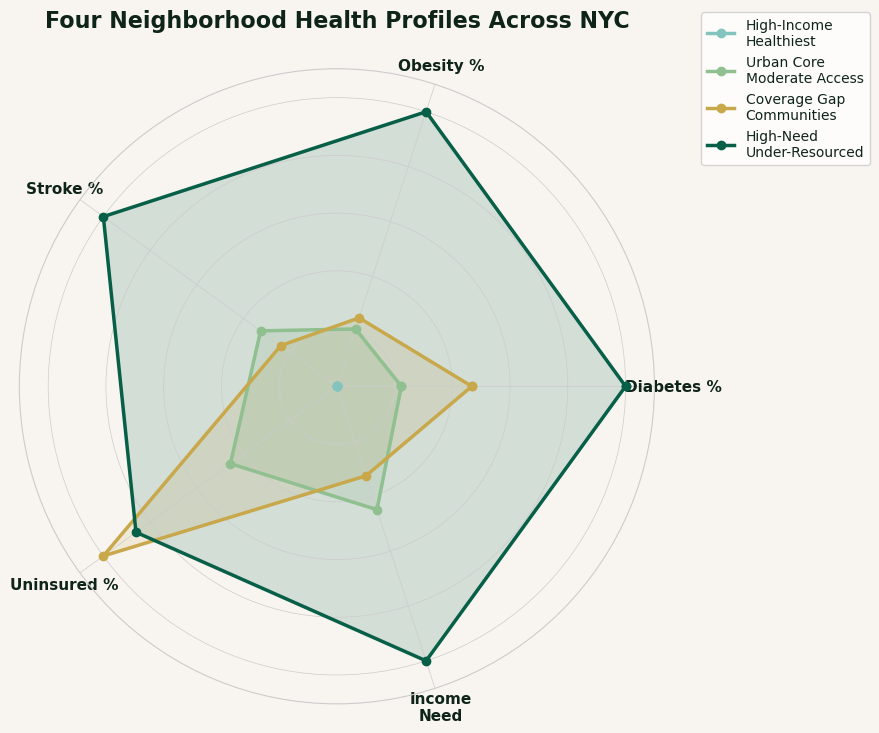

Saved: cluster_radar_profiles.jpg and .png


In [79]:
## VISUAL 2: Cluster Profiles (Radar/Spider Chart)
# Shows cluster profiles across 5 health/economic dimensions

# Portolio Colors
cream = '#f8f5f0'
dark_green = '#0f2419'

# Cluster colors (from README plan)
cluster_colors = {
    'High-Income\nHealthiest': '#83C5BE',            # light blue (Cluster 0)
    'Urban Core\nModerate Access': '#90BF90',         # light green  (Cluster 1)
    'Coverage Gap\nCommunities': '#c9a84c',           # gold (Cluster 2)
    'High-Need\nUnder-Resourced': '#065F46'           # darkest green (Cluster 3)
}

# Verified Cluster Data (from Notebook 05, Cell 25)
# Raw values
raw_data = {
    'High-Income\nHealthiest':        [8.97, 23.13, 2.61, 4.11, 102357],
    'Urban Core\nModerate Access':    [10.27, 25.46, 3.10, 5.61, 80023],
    'Coverage Gap\nCommunities':      [11.69, 25.91, 2.97, 7.40, 86150],
    'High-Need\nUnder-Resourced':     [14.79, 34.28, 4.11, 6.94, 52657],
}

# Metrics: Diabetes, Obesity, Uninsured, Stroke, Income (will be inverted)
metrics = ['Diabetes %', 'Obesity %', 'Stroke %', 'Uninsured %', 'Income\nNeed']

# Normalize to 0-1 scale 
# For each metric, find min and max across all clusters, then scale
# Income gets INVERTED so higher = more need (lower income)

all_values = list(raw_data.values())

# Get min/max for each of the 5 metrics
mins = [min(v[i] for v in all_values) for i in range(5)]
maxs = [max(v[i] for v in all_values) for i in range(5)]

normalized_data = {}
for name, values in raw_data.items():
    normed = []
    for i in range(5):
        if i == 4:  # Income — INVERT (lower income = higher need)
            normed.append(1 - (values[i] - mins[i]) / (maxs[i] - mins[i]))
        else:
            normed.append((values[i] - mins[i]) / (maxs[i] - mins[i]))
    normalized_data[name] = normed

# Build the Radar Chart
num_vars = len(metrics)

# Calculate angles for each axis
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # close the polygon

fig, ax = plt.subplots(figsize=(9, 9), subplot_kw=dict(polar=True))
fig.patch.set_facecolor(cream)
ax.set_facecolor(cream)

# Draw each cluster
for name, values in normalized_data.items():
    values_closed = values + values[:1]  # close the shape
    color = cluster_colors[name]

    ax.plot(angles, values_closed, 'o-', linewidth=2.5,
            color=color, label=name)
    ax.fill(angles, values_closed, alpha=0.15, color=color)

# Axis labels
ax.set_xticks(angles[:-1])
ax.set_xticklabels(metrics, fontsize=11, fontweight='bold', color=dark_green)

# Clean up the radial grid
ax.set_yticklabels([])  # hide radial numbers
ax.set_ylim(0, 1.1)

# Style the grid
ax.spines['polar'].set_color('#cccccc')
ax.grid(color='#cccccc', linewidth=0.5)

# Title
ax.set_title('Four Neighborhood Health Profiles Across NYC',
             fontsize=16, fontweight='bold', color=dark_green,
             pad=30)

# Legend
ax.legend(loc='upper right', bbox_to_anchor=(1.35, 1.1),
          fontsize=10, frameon=True, facecolor='white',
          edgecolor='#cccccc', labelcolor=dark_green)

plt.tight_layout()

# Save ---
plt.savefig('/Users/jessduong/Documents/CF/Achievement 6/04 analysis/visualizations/cluster_radar_profiles.png',
            dpi=300, bbox_inches='tight', facecolor=cream)

plt.show()
print("Saved: cluster_radar_profiles.jpg and .png")

### Four Neighborhood Health Profiles (Radar Chart)

This radar chart compares the four K-means clusters across five normalized dimensions: Diabetes, Obesity, Stroke, Uninsured rate, and Income Need (inverted so higher values represent greater need). Cluster 3 (High-Need, Under-Resourced) dominates across all dimensions with the largest footprint, while Cluster 0 (High-Income, Healthiest) shows the smallest. The clear expansion from inner to outer profiles reinforces that health disparities in NYC follow a consistent income gradient — communities with lower income experience worse outcomes across every metric measured.
Drop each one as a Markdown cell right above its matching code cell.